In [ ]:
!pip install torchmetrics datasets transformers kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1


In [3]:
import pandas as pd


fake_df = pd.read_csv(path + '/Fake.csv')
true_df = pd.read_csv(path + '/True.csv')
print(fake_df.head())
print(true_df.head())


                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

In [4]:
fake_df.describe()
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [5]:

data_set = pd.concat([true_df, fake_df], ignore_index=True)
data_set["labels"] = 0  # Assign 0 to all labels initially
data_set.loc[data_set.index >= len(true_df), "labels"] = 1 #Update the labels of the fake news
data_set.head()


,title,text,subject,date,labels
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [6]:
from sklearn.utils import shuffle

data_set = shuffle(data_set, random_state=42)

data_set[:10]

,title,text,subject,date,labels
22216,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
27917,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
25007,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
1377,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
32476,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1
5766,"As private lawyer, Trump high court pick was f...",WASHINGTON (Reuters) - As a lawyer in private ...,politicsNews,"February 1, 2017",0
16230,Yemeni Salafist imam killed in Aden: sources,ADEN (Reuters) - A Salafist imam was shot dead...,worldnews,"October 28, 2017",0
20911,FBI says witnesses in U.S. probe into Malaysia...,KUALA LUMPUR (Reuters) - Potential witnesses t...,worldnews,"September 6, 2017",0
35838,An Easy To Read Chart Shows How Bernie Sanders...,The goal of socialism is communism. -Vladimi...,politics,"Feb 24, 2016",1
33155,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...,Opposing views and beliefs has much of this co...,politics,"Feb 4, 2017",1


In [7]:
from datasets import Dataset

raw_data_set = Dataset.from_pandas(data_set)
raw_data_set

Dataset({
    features: ['title', 'text', 'subject', 'date', 'labels', '__index_level_0__'],
    num_rows: 44898
})

In [8]:
from datasets import DatasetDict

# 'data_set' is Hugging Face Dataset object

data_set = DatasetDict({
    "train": raw_data_set.train_test_split(test_size=0.2, seed=42)["train"],
    "validation": raw_data_set.train_test_split(test_size=0.2, seed=42)["test"]
})

data_set


DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'labels', '__index_level_0__'],
        num_rows: 35918
    })
    validation: Dataset({
        features: ['title', 'text', 'subject', 'date', 'labels', '__index_level_0__'],
        num_rows: 8980
    })
})

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, DataCollatorWithPadding


checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)


tokenized_datasets = data_set.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

In [11]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35918
    })
    validation: Dataset({
        features: ['title', 'text', 'subject', 'date', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8980
    })
})

In [12]:

tokenized_datasets = tokenized_datasets.remove_columns(["text", "title", "subject", "date","__index_level_0__"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names


['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=16, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=16, collate_fn=data_collator
)

In [14]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([16]),
 'input_ids': torch.Size([16, 512]),
 'token_type_ids': torch.Size([16, 512]),
 'attention_mask': torch.Size([16, 512])}

In [15]:
outputs = model(**batch)

print(outputs.loss, outputs.logits.shape)

tensor(0.8278, grad_fn=<NllLossBackward0>) torch.Size([16, 2])


In [16]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

2245


In [18]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [19]:
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy, F1Score

num_classes = 2

# Move metrics to GPU
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes, average="weighted").to(device)

# Tracking loss for plotting
train_losses = []
val_losses = []
iteration_losses = []  # Track loss per iteration
iterations = []  # Track iteration numbers

progress_bar = tqdm(range(num_training_steps))

model.to(device)
model.train()
iteration = 0

for epoch in range(num_epochs):
    total_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        labels = batch["labels"]

        # Update metrics
        accuracy_metric.update(preds, labels)
        f1_metric.update(preds, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        total_loss += loss.item()
        iteration += 1
        iteration_losses.append(loss.item())
        iterations.append(iteration)

        # Print loss every 100 steps
        if (step + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Step {step + 1}: Loss = {loss.item():.4f}")

    # Compute training metrics
    train_accuracy = accuracy_metric.compute().item()
    train_f1 = f1_metric.compute().item()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Accuracy = {train_accuracy:.4f}, F1 = {train_f1:.4f}")

    # Validation step
    model.eval()
    val_loss = 0
    accuracy_metric.reset()
    f1_metric.reset()

    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            labels = batch["labels"]

            # Update metrics
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)

            val_loss += loss.item()

    val_accuracy = accuracy_metric.compute().item()
    val_f1 = f1_metric.compute().item()
    avg_val_loss = val_loss / len(eval_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}: Validation Loss = {avg_val_loss:.4f}, Accuracy = {val_accuracy:.4f}, F1 = {val_f1:.4f}")

    model.train()  # Switch back to training mode


  0%|          | 0/2245 [00:00<?, ?it/s]

Epoch 1, Step 100: Loss = 0.0495
Epoch 1, Step 200: Loss = 0.0193
Epoch 1, Step 300: Loss = 0.0085
Epoch 1, Step 400: Loss = 0.0080
Epoch 1, Step 500: Loss = 0.0043
Epoch 1, Step 600: Loss = 0.0028
Epoch 1, Step 700: Loss = 0.0029
Epoch 1, Step 800: Loss = 0.0020
Epoch 1, Step 900: Loss = 0.0024
Epoch 1, Step 1000: Loss = 0.0012
Epoch 1, Step 1100: Loss = 0.0014
Epoch 1, Step 1200: Loss = 0.0010
Epoch 1, Step 1300: Loss = 0.0019
Epoch 1, Step 1400: Loss = 0.0010
Epoch 1, Step 1500: Loss = 0.0009
Epoch 1, Step 1600: Loss = 0.0006
Epoch 1, Step 1700: Loss = 0.0009
Epoch 1, Step 1800: Loss = 0.0007
Epoch 1, Step 1900: Loss = 0.0007
Epoch 1, Step 2000: Loss = 0.0007
Epoch 1, Step 2100: Loss = 0.0011
Epoch 1, Step 2200: Loss = 0.0013
Epoch 1: Train Loss = 0.0170, Accuracy = 0.9957, F1 = 0.9957
Epoch 1: Validation Loss = 0.0009, Accuracy = 1.0000, F1 = 1.0000


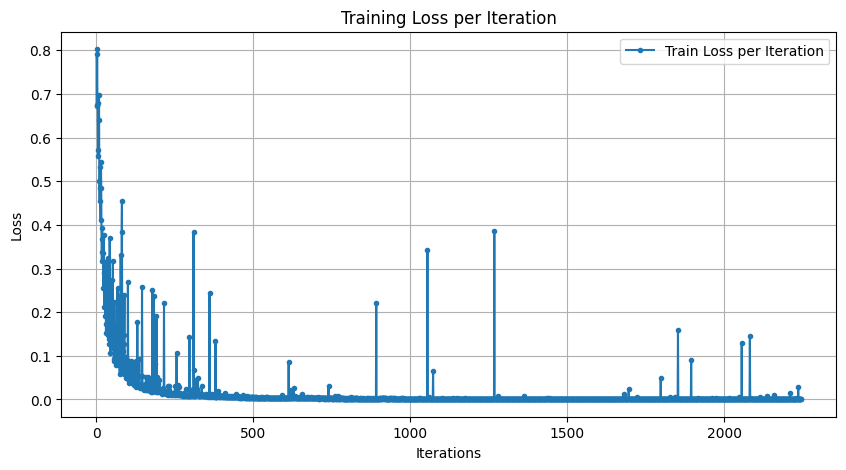

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, iteration_losses, label="Train Loss per Iteration", marker=".")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss per Iteration")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
#Fake News Detection
def predict_fake_news(text, tokenizer, model, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    return "Fake News" if prediction == 1 else "Real News"

# Example Fake News Text
test_text = "Breaking: Scientists discover a new planet made entirely of gold!"
prediction = predict_fake_news(test_text, tokenizer, model, device)
print(f"Prediction: {prediction}")


Prediction: Fake News
